##### 辨識微笑，拍照儲存
這篇文章將「倒數計時自動拍照效果」以及「情緒辨識與年齡偵測」兩篇文章的範例合併，實作偵測影像中的人臉是否微笑，如果出現微笑表情，就會倒數三秒自動拍照儲存。

* 參考：\
[倒數計時自動拍照效果](https://steam.oxxostudio.tw/category/python/ai/opencv-take-picture.html)\
[情緒辨識與年齡偵測](https://steam.oxxostudio.tw/category/python/ai/ai-emotion.html)

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 辨識微笑，拍照儲存 
使用「倒數計時自動拍照效果」的範例，加入情緒辨識的功能，當偵測到情緒反應的 happy 數值大於 0.5 的時候，就認定人臉正在微笑，近一步觸發拍照的功能，詳細說明寫在下方程式碼中：

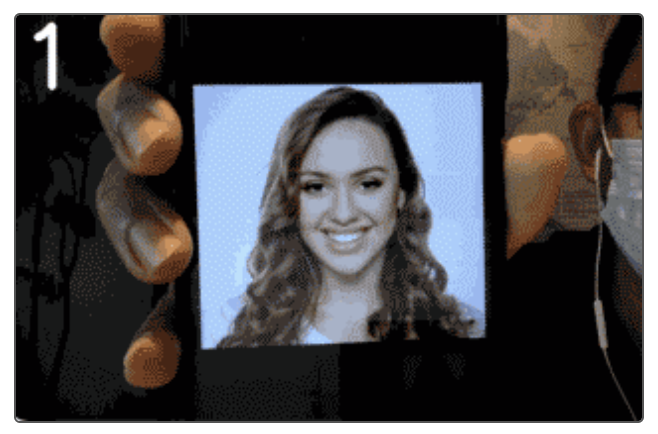

In [ ]:
import cv2
import numpy as np
from deepface import DeepFace    # 載入 deepface

cap = cv2.VideoCapture(0)        # 讀取攝影鏡頭

# 定義在畫面中放入文字的函式
def putText(source, x, y, text, scale=2.5, color=(255,255,255)):
    """
    在圖片上放入文字

    參數:
    source (ndarray): 來源圖片
    x (int): 文字的 x 座標
    y (int): 文字的 y 座標
    text (str): 要顯示的文字
    scale (float): 文字大小比例
    color (tuple): 文字顏色 (B, G, R)
    """
    org = (x, y)
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = scale
    thickness = 5
    lineType = cv2.LINE_AA
    cv2.putText(source, text, org, fontFace, fontScale, color, thickness, lineType)


a = 0        # 白色圖片透明度
happy = 0    # 是否有 happy 的變數

if not cap.isOpened():
    print("Cannot open camera")
    exit()

while True:
    ret, img = cap.read()               # 讀取影片的每一幀
    if not ret:
        print("Cannot receive frame")   # 如果讀取錯誤，印出訊息
        break
    img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)   # 轉換成 BGRA，目的為了和白色圖片組合
    w = int(img.shape[1] * 0.5)           # 取得圖片寬度的 1/2
    h = int(img.shape[0] * 0.5)           # 取得圖片高度的 1/2
    img = cv2.resize(img, (w, h))         # 縮小圖片尺寸 (加快處理速度)
    white = 255 - np.zeros((h, w, 4), dtype='uint8')   # 產生全白圖片

    key = cv2.waitKey(1)                # 每隔一毫秒取得鍵盤輸入資訊

    try:
        emotion = DeepFace.analyze(img, actions=['emotion'], enforce_detection=False)  # 設定 enforce_detection 為 False
        print(emotion['emotion']['happy'], emotion['emotion']['neutral'])  # 印出數值
        if emotion['emotion']['happy'] > 0.5:
            happy += 1       # 如果具有一點點 happy 的數值，就認定正在微笑，將 happy 增加 1
        else:
            happy = 0               # 如果沒有 happy，將 happy 歸零
    except Exception as e:
        print(f"Error analyzing emotion: {e}")
        happy = 0

    if happy == 1:
        a = 1                # 如果 happy 等於 1，將 a 變成 1 ，觸發拍照程式
        sec = 4              # 倒數秒數從 4 開始

    if key == 32:            # 按下空白將 a 等於 1 (按下空白也可以拍照)
        a = 1
        sec = 4
    elif key == ord('q'):    # 按下 q 結束
        break

    if a == 0:
        output = img.copy()  # 如果 a 為 0，設定 output 和 photo 變數
    else:
        if happy >= 1:
            output = img.copy()
            photo = img.copy()
            sec -= 0.5       # 根據個人電腦效能，設定到接近倒數三秒
            putText(output, 10, 70, str(int(sec)))
            if sec < 1:
                output = cv2.addWeighted(white, a, photo, 1 - a, 0)  # 計算權重，產生白色慢慢消失效果
                a -= 0.5
                print('a', a)
                if a <= 0:
                    a = 0
                    cv2.imshow('Captured Photo', photo)  # 顯示拍照後的圖片
        else:
            a = 0
            pass
    cv2.imshow('oxxostudio', output)               # 顯示圖片

cap.release()                           # 所有作業都完成後，釋放資源
cv2.destroyAllWindows()                 # 結束所有視窗